In [1]:
#LIBRARIES

# VREP API library
import sim
import sys
from matplotlib import pyplot as plt
from matplotlib import use

# import numpy and 
import numpy as np
import time

In [10]:


def getSensorValues(sc,sl,sr):
    _, _, dPC, _, _=sim.simxReadProximitySensor(clientID,sc, sim.simx_opmode_blocking)
    _, _, dPL, _, _=sim.simxReadProximitySensor(clientID,sl, sim.simx_opmode_blocking)
    _, _, dPR, _, _=sim.simxReadProximitySensor(clientID,sr, sim.simx_opmode_blocking)
    return np.linalg.norm(dPC),np.linalg.norm(dPL),np.linalg.norm(dPR)

def getSensorHandles():
    err,Sensor_Cara=sim.simxGetObjectHandle(clientID,'Sensor_Cara',sim.simx_opmode_blocking)
    err,Sensor_left=sim.simxGetObjectHandle(clientID,'Sensor_left',sim.simx_opmode_blocking)
    err,Sensor_right=sim.simxGetObjectHandle(clientID,'Sensor_right',sim.simx_opmode_blocking)
    return Sensor_Cara, Sensor_left, Sensor_right

# CONNECTION   
def conn():
    #close all connections
    sim.simxFinish(-1)
    # connection with the API
    clientID = -1
    while clientID == -1:
        print("Conectando...")
        clientID = sim.simxStart('127.0.0.1', 19999,True,True,2000,5)
    print("Conectado al puerto 19999")
    return clientID
    
# INITIALIZE ROTORS TO 0
def init_prop(clientID): 
    r,r1,r2,r3,r4 = sim.simxCallScriptFunction(clientID, "Quadricopter", sim.sim_scripttype_childscript,"set_v", [], [0,0,0,0], [] ,"", sim.simx_opmode_blocking)

# MOVING THE DRONE AS AN OBJECT
def move_q(pos):
    err, qcopter = sim.simxGetObjectHandle(clientID, 'Quadricopter_target', sim.simx_opmode_blocking)
    sim.simxSetObjectPosition(clientID, qcopter, -1, pos, sim.simx_opmode_oneshot)
    time.sleep(0.07)

# ROTATE THE DRONE AS AN OBJECT
   

# FUNCTION THAT SETS VELOCITIES TO EACH PROPELER
def move_prop(clientID, vels):
     r,r1,r2,r3,r4 = sim.simxCallScriptFunction(clientID, "Quadricopter", sim.sim_scripttype_childscript,"set_v", [], vels, [] ,"", sim.simx_opmode_blocking)


In [3]:
def in_box(pa,box):
    return (box[0][0] < pa[0] < box[1][0]) and (box[0][1] < pa[1] < box[1][1])

def recta(x,pos_ini,pos_end):
    y=((pos_end[1]-pos_ini[1])/(pos_end[0]-pos_ini[0]))*(x-pos_ini[0])
    return y

def algoritme2(pos_ini,pos_end):
    sc,sl,sr = getSensorHandles()
    pos_actual=pos_ini
    # log dels sensors
    sensor_log = []
    # area de aterrizatge
    box = [[pos_end[0] - 0.3,pos_end[1] - 0.3], [pos_end[0] + 0.3, pos_end[1] +0.3]]
    h_change = 0
    gir=0# 1 dreta,2 esquerra
    sc_act,sl_act,sr_act = [0,0,0]
    # mentre no estem a l'area final(box)
    while not in_box(pos_actual,box):
        # Valors dels sensors
        sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
        sensor_log.append([sc_act,sl_act,sr_act])
        # Hi ha alguna cosa davant
        if (sc_v < 0.8 and  sc_v > 0.1 ):
            sc_act=1
            #Hi ha alguna cosa a l'esquerra i no hi ha res a la dreta, per tant movem a la dreta
            if (sl_v < 0.8 and  sl_v > 0.1):
                sl_act=1
                # Si també hi ha una cosa a la dreta movem cap amunt
                if (sr_v < 0.8 and  sr_v > 0.1):
                    sr_act = 1
                    print("Movent cap amunt")
                    pos_actual[2] = pos_actual[2] + 0.1
                    move_q(pos_actual)
                    h_change=1
                    continue
                # Moviment a la dreta
                print("Movent a la dreta")
                pos_actual[1] = pos_actual[1] -0.1
                move_q(pos_actual)
                gir = 1
            else:
                print("Movent a l'esquerra")
                # Si no hi ha res a l'esquerra Movem cap a l'esquerra
                pos_actual[1] = pos_actual[1] +0.1
                move_q(pos_actual) 
                gir = 2
        
        else:
            print("Sense obstacles, seguim recte")
            # Calculem si el punt actual està a la recta
            y = recta(pos_actual[0],pos_ini,pos_end)
            # Si està a la recta podem seguir endavant, si no és que estem vorejant un objecte
            if pos_actual[1]-0.1 < y < pos_actual[1]+0.1:
                pos_actual[0]=pos_actual[0]+0.1
                y = recta(pos_actual[0],pos_ini,pos_end)
                move_q(pos_actual)
            else:
                # creem una variable per veure si mentre estem avançant trobem un altre objecte davant
                # si es el cas l'hem de vorejar també
                front_obj = 0
                # ara avancem una mica fins detectar l'objecte que estem vorejant
                sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                # En el cas d'haver canviat d' altura no entrarem
                while (not ((sl_v < 0.8 and  sl_v > 0.1) or (sr_v < 0.8 and  sr_v > 0.1)) and front_obj == 0 and h_change == 0 and in_box(pos_actual,box)==False):
                    sensor_log.append([sc_act,sl_act,sr_act])
                    print("Endavant fins detectar")
                    # si el sensor frontal detecta una altre objecte 
                    if(sc_v < 0.8 and  sc_v > 0.1):
                        # marquem l'objecte com a detectat
                        front_obj = 1
                        continue
                    pos_actual[0] = pos_actual[0]+0.1
                    move_q(pos_actual)
                    sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                sc_act,sl_act,sr_act =[int(sc_v < 0.8 and  sc_v > 0.1) ,int(sl_v < 0.8 and  sl_v > 0.1), int(sr_v < 0.8 and  sr_v > 0.1)]
                # si hem detectat un objecte hem de vorejar-lo també, per tant anem a la següent iteració del while general
                if front_obj == 1:
                    continue
                # Un cop haguem detectat l'objecte que estem vorejant fins que no el deixem de detectar seguim endavant també
                while ((sl_v < 0.8 and  sl_v > 0.1) or (sr_v < 0.8 and  sr_v > 0.1) and front_obj == 0 and in_box(pos_actual,box)==False):
                    print("Endavant fins  no detectar")
                    sensor_log.append([sc_act,sl_act,sr_act])
                    if(sc_v < 0.8 and  sc_v > 0.1):
                        # marquem l'objecte com a detectat
                        front_obj = 1
                        continue
                    pos_actual[0] = pos_actual[0]+0.1
                    move_q(pos_actual)
                    sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                    sc_act,sl_act,sr_act =[int(sc_v < 0.8 and  sc_v > 0.1) ,int(sl_v < 0.8 and  sl_v > 0.1), int(sr_v < 0.8 and  sr_v > 0.1)]
                
                # si hem detectat un objecte hem de vorejar-lo també, per tant anem a la següent iteració del while general
                if front_obj == 1:
                    continue
                # Ara volem tornar a la recta
                #Avancem una mica més per no xocar contra l'objecte
                pos_actual[0] = pos_actual[0]+0.1
                move_q(pos_actual)
                # Ara tenint en compte el gir tornem a la recta
                y = recta(pos_actual[0],pos_ini,pos_end)
                if (gir==1 and in_box(pos_actual,box)==False) :
                    # Tornem desde la dreta
                    print("Tornem desde la dreta")
                    while y > pos_actual[1]:
                        sensor_log.append([sc_act,sl_act,sr_act])
                        if (sl_v < 0.8 and  sl_v > 0.1):
                            print("Objecte trobat a l'esquerra, tirant endavant")
                            pos_actual[0] = pos_actual[0]+0.1
                            move_q(pos_actual)
                            sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                            sc_act,sl_act,sr_act =[int(sc_v < 0.8 and  sc_v > 0.1) ,int(sl_v < 0.8 and  sl_v > 0.1), int(sr_v < 0.8 and  sr_v > 0.1)]
                            continue
                        print("Tornant...")
                        pos_actual[1] = pos_actual[1]+0.1
                        move_q(pos_actual)
                        sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                        sc_act,sl_act,sr_act =[int(sc_v < 0.8 and  sc_v > 0.1) ,int(sl_v < 0.8 and  sl_v > 0.1), int(sr_v < 0.8 and  sr_v > 0.1)]
                else:
                    if(in_box(pos_actual,box)==False):
                        # Tornem desde la esquerra
                        print("Tornem desde la esquerra",y,pos_actual[1])
                        sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                        while y < pos_actual[1]:
                            sensor_log.append([sc_act,sl_act,sr_act])
                            if (sr_v < 0.8 and  sr_v > 0.1):
                                print("Objecte trobat a la dreta, tirant endavant")
                                pos_actual[0] = pos_actual[0]+0.1
                                move_q(pos_actual)
                                sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                                sc_act,sl_act,sr_act =[int(sc_v < 0.8 and  sc_v > 0.1) ,int(sl_v < 0.8 and  sl_v > 0.1), int(sr_v < 0.8 and  sr_v > 0.1)]
                                continue
                            print("Tornant...")
                            pos_actual[1] = pos_actual[1]-0.1
                            move_q(pos_actual)
                            sc_v,sl_v,sr_v = getSensorValues(sc,sl,sr)
                            sc_act,sl_act,sr_act =[int(sc_v < 0.8 and  sc_v > 0.1) ,int(sl_v < 0.8 and  sl_v > 0.1), int(sr_v < 0.8 and  sr_v > 0.1)]
    # Bucle per tornar a la altura inicial
    while pos_actual[2]-pos_end[2] > 0.1:
        pos_actual[2] = pos_actual[2] -0.05
        move_q(pos_actual)
    return sensor_log 

In [17]:
clientID = conn()
# posició inicial
x = -1.8
y= 0.0
z=0.5
pos_ini = [x,y,z]
move_q(pos_ini)
#posició final
pos_end = [1.8,y,z]
# crida a l'algorisme
sensor_log = algoritme2(pos_ini,pos_end)

Conectando...
Conectado al puerto 19999
Sense obstacles, seguim recte
Sense obstacles, seguim recte
Sense obstacles, seguim recte
Sense obstacles, seguim recte
Sense obstacles, seguim recte
Sense obstacles, seguim recte
Sense obstacles, seguim recte
Sense obstacles, seguim recte
Movent a l'esquerra
Movent a l'esquerra
Movent a l'esquerra
Movent a l'esquerra
Movent a l'esquerra
Movent a l'esquerra
Sense obstacles, seguim recte
Endavant fins detectar
Endavant fins detectar
Endavant fins detectar
Endavant fins detectar
Endavant fins detectar
Endavant fins detectar
Endavant fins detectar
Endavant fins detectar
Movent a l'esquerra
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent cap amunt
Movent ca

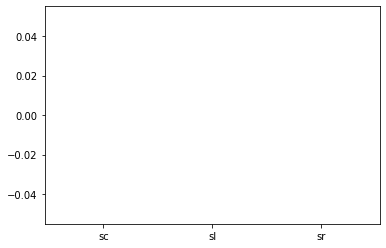

In [76]:
# Grafiquem els logs dels sensors
num_events = len(sensor_log)
bins = ["sc","sl","sr"]
# fig, ax = plt.subplots()
# rects = ax.bar(bins, np.ones(3))
plt.ion()
fig,ax = plt.subplots()
barchart = ax.bar(bins,[0,0,0],)
for i in range(num_events):
    for bar, val in zip(barchart, sensor_log[i]):
        bar.set_height(val)
    plt.draw()
    """
    # fig, ax = plt.subplots()
    for rect, h in zip(rects, sensor_log[i]):
        rect.set_height(h)
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.1)
    """

In [10]:
# to be able to use window
use("Qt5Agg")
def animated_barplot(events, bins):
    # http://www.scipy.org/Cookbook/Matplotlib/Animations
    
    rects = plt.bar(bins, len(events),  align = 'center')
    for i in range(len(events)):
        for rect, h in zip(rects, events):
            rect.set_height(h)
        fig.canvas.draw()

fig = plt.figure()
setupUI()
win = fig.canvas.manager.window
win.after(100, animated_barplot(sensor_log,["sc","sl","sr"]))
plt.show()

AttributeError: 'MainWindow' object has no attribute 'after'